# Going Deeper(CV)
# 12. GO/STOP! - Object Detection 시스템 만들기 [프로젝트]

## 12. GO/STOP! - Object Detection 시스템 만들기 [프로젝트]

In [72]:
import tensorflow as tf

print(tf.__version__)

2.6.0


### 라이브러리와 데이터 불러오기

In [73]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

In [74]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

### 데이터 확인하기

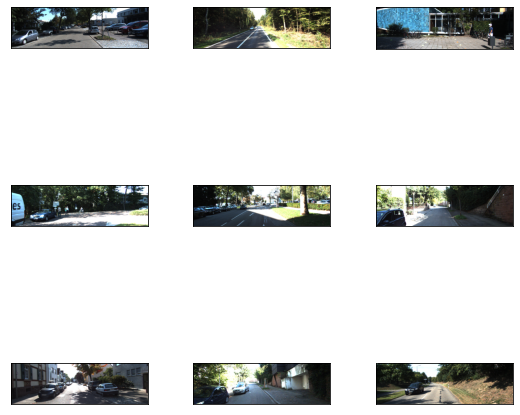

In [75]:
_ = tfds.show_examples(ds_train, ds_info)

In [76]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.7 , 1.64], dtype=float32)>, 'bbox': <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.42168   , 0.41061193, 0.5122667 , 0.44844607],
       [0.47688   , 0.45328504, 0.5187733 , 0.47110307]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.5 , 1.7 , 4.21],
       [1.48, 1.87, 4.42]], dtype=float32)>, 'location': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-3.63,  1.99, 34.57],
       [-3.52,  2.24, 71.08]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>, 'rotation_y': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.59, 1.59], dtype=float32)>, 'truncated': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>, 'type': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>}


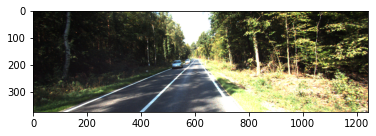

In [77]:
sample = ds_train.take(1)

for example in sample:
    print('------Example------')
    print(list(example.keys()))
    image = example['image']
    filename = example['image/file_name'].numpy().decode('utf-8')
    objects = example['objects']
    
print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)

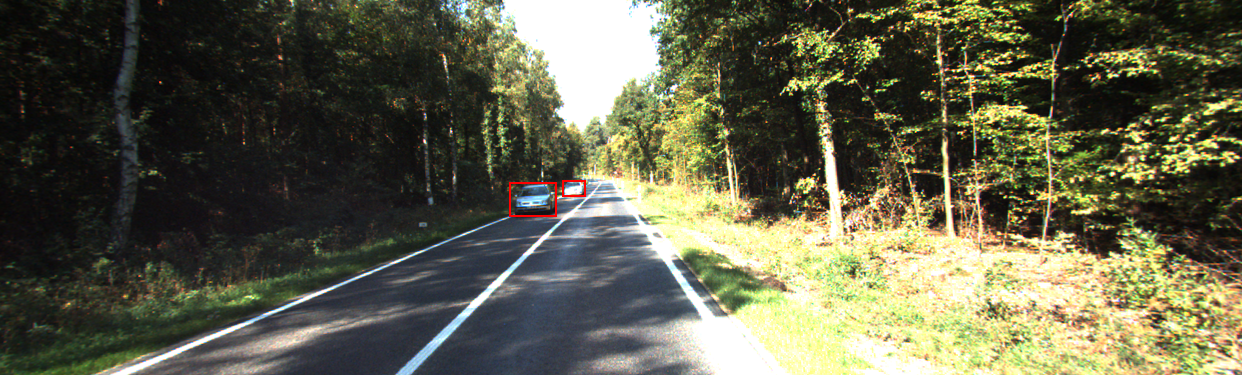

In [78]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    w, h = img.size
    
    for bbox in object_bbox[:]:
        y_min, x_min, y_max, x_max = bbox
        x_min *= w
        x_max *= w
        y_min = h - y_min * h
        y_max = h - y_max * h
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=(255, 0, 0), width=2)
    
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### 데이터 준비

#### 데이터 파이프 라인

In [79]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [80]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes

In [81]:
def resize_and_pad_image(image, training=True):
    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

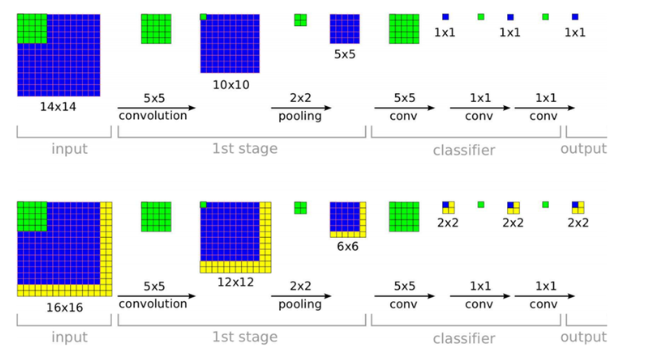

처음엔 그림만 보고 복잡하게 생각해서 output 이미지에 많은 더 많은 정보를 담기 위해서 패딩을 사용한다고 생각했습니다. 물론 결과적으론 그런 이점이 있는 것 같습니다. 한 픽셀에 모든 이미지이 정보를 담는 것보단 여러 픽셀에 이미지의 여러 부분을 서로 겹치게 담고 있는 것이 더 유리할 것 같기 때문입니다.


하지만 좀 더 단순하게 생각해보니 5*5 컨볼루션 마스크를 사용하면 테두리의 정보가 2픽셀식 소실되기 때문에 2픽셀 크기의 패딩을 더하여 이미지 테두리 부분에 위치한 픽셀들의 정보를 반영한 것 같습니다. 패딩의 기본적인 존재 이유였는데 처음에 너무 어렵게 생각한 것 같습니다.

In [82]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

In [83]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

#### 인코딩

In [84]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]    # 앵커박스의 가로 세로 비율(작을수록 가로로 김)
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]    # 앵커박스의 크기를 결정

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)    # 종횡비 개수 * 크기 개수 = 앵커박스의 모든 가능한 조합 개수
        self._strides = [2 ** i for i in range(3, 8)]    # 특성 맵(컨볼루션 결과)의 크기에 따라서 앵커박스간의 거리 조절하기 위함
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]    # 앵커박스의 넓이를 특성 맵의 크기에 따라 조절하기 위함
        self._anchor_dims = self._compute_dims()    # 앵커 박스의 차원 정보

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)    # ratio와 앵커박스 넓이를 활용해 앵커박스 세로 길이구하기
                anchor_width = area / anchor_height    # 앵커박스 가로 길이 구하기
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]    # [1, 1, 2]의 형태로 변환(2=앵커박스의 가로세로)
                )    # 차원을 추가하는 이유는 컨볼루션 연산 결과로 나온 특성맵과 연산을 하기 위해 차원을 일치시키는 것
                for scale in self.scales:
                    anchor_dims.append(scale * dims)    # 다양한 크기 비율의 앵커박스 생성하여 anchor_dims에 저장
                    # [앵커 박스 비율에 대한 차원[앵커 박스의 스케일에 대한 차원[앵커 박스의 가로세로에 대한 차원]]] = [1, 1, 2] 형태
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))    # anchor_dims_all에 anchor_dims 배열들을 append함
            # [[앵커 박스 비율에 대한 차원[앵커 박스의 스케일에 대한 차원[앵커 박스의 가로세로에 대한 차원]]]] = [1, 1, 1, 2] 형태
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):   # level = 특성 맵의 레벨(층)
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5    # feature_width를 기준으로 한 열 벡터 생성([0.5, 1.5, 2.5,..]같은 형상)
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5   # feature_height를 기준으로 한 열 벡터 생성([0.5, 1.5, 2.5,..]같은 형상)
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3] # rx와 ry를 조합해 2차원 그리드 생성(strides로 간격)
        centers = tf.expand_dims(centers, axis=-2) # 앵커박스와 centers의 차원 일치(features_height, features_width, 1, 2) > 1이 추가됨
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])  # (features_height, features_width, _num_anchors, 2)
        dims = tf.tile(    # _anchor_dims를 feature_height, feature_width만큼 복제 > (feature_height, feature_width, _num_anchors, 2)
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1] # level - 3 하는 이유 > range(3, 8)을 (0, 5)로 바꿔 인덱싱
        )
        anchors = tf.concat([centers, dims], axis=-1) # centers, dims를 합침 > (feature_height, feature_width, _num_anchors, 4)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4] # (feature_height * feature_width * _num_anchors, 4)
        )

    def get_anchors(self, image_height, image_width):
        anchors = [ # 각 레벨(3~7)에 대해 앵커 박스를 생성
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i), # 해당 레벨에서의 특성 맵의 크기, 레벨이 증가할수록 특성 맵의 크기가 작아짐
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0) # 3~7레벨의 앵커박스들을 전부 합쳐 하나의 텐서로 결합

간단히 정리하면 각 층마다 특성 맵들의 크기를 결정하고, 특성 맵의 크기에 맞춰 앵커 박스간의 거리를 조절하여 앵커박스들로 일정 간격의 그리드를 생성합니다.  
그리고 앵커박스들의 정보가 담긴 텐서를 반환합니다.  

처음에 왜 get_anchors가 두 개나 필요한지도 궁금하고 정확한 동작 방식이 궁금해서 한 줄씩 뜯어봤는데, _get_anchors로 한 층에서의 앵커박스들로 이루어진 그리드를 생성하고 이 앵커박스들의 정보를 배열의 형식으로 만든 후, get_anchors에서 여러 층을 반복문으로 돌려 _get_anchors를 호출하는 것이었습니다...

In [85]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [86]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes( # 앵커박스와 실제 객체의 바운딩 박스 간의 매칭 수행
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou) # max_iou가 0.5보다 클 경우 positive_mask
        negative_mask = tf.less(max_iou, ignore_iou) # max_iou가 0.4보다 작을 경우 negative_mask
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask)) # positive도 negative도 아닐 경우 ignore
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:], # 실제 바운딩 박스 중심과 앵커박스 중심의 차이 계산
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2]) # 앵커박스 호출
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes( # 앵커박스와 바운딩박스간의 매칭 결과 호출
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx) # 매칭된 실제 바운딩 박스 선택
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes) # 앵커박스와 매칭된 실제 바운딩 박스간의 차이 계산
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where( # positive mask 여부
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target) # ignore mask 여부
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

### 모델 작성

#### Feature Pyramid

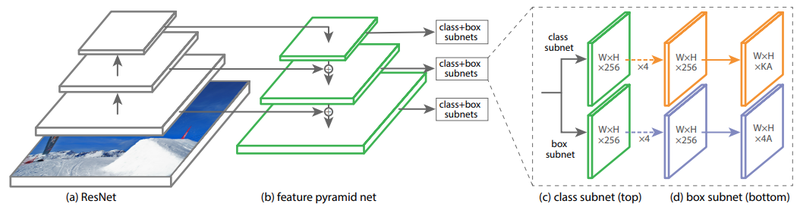

[참고 링크1](https://darkpgmr.tistory.com/137)

Feature Pyramid에서 여러 층의 출력값을 불러오는 이유는 입력 이미지를 여러가지 스케일로 볼 수 있기 때문입니다. 
왜 여러가지 스케일로 볼 수 있는 것이 중요할까요?  
바로 이미지를 인식하는 데 있어서 다양한 물체를 검출하기에 유리하기 때문입니다.

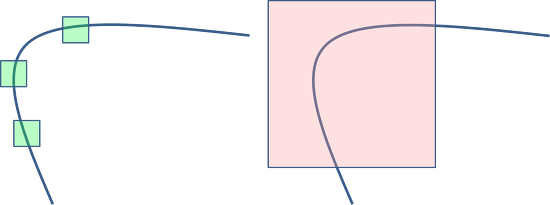

예를 들어 같은 크기의 앵커박스를 사용하여 물체를 인식하려면 작은 물체는 쉽게 찾을 수 있지만 큰 물체는 찾기 힘들 것입니다. 따라서 여러 스케일에 걸쳐서 이미지를 처리하면 물체가 크던 작던 상관없이 인식을 할 수 있을 것입니다.

In [87]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output) # 상위 레벨의 특성 맵은 업샘플링하여 하위 레벨의 특성 맵과 결합
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

- 각 층마다 특성 맵을 뽑아냅니다.
- 상위 층의 특성 맵들을 업샘플링하여 하위 층의 특성 맵과 합연산합니다.
- 이렇게 얻어진 각 층의 결과 predict를 다시 컨볼루션 연산합니다.
- 최종적으로 클래스와 box에 대한 특성 맵을 얻을 수 있습니다.

그런데 ResNet50은 크게 5가지 블록으로 이루어졌는데 어째서 output은 3개만 사용할까요?

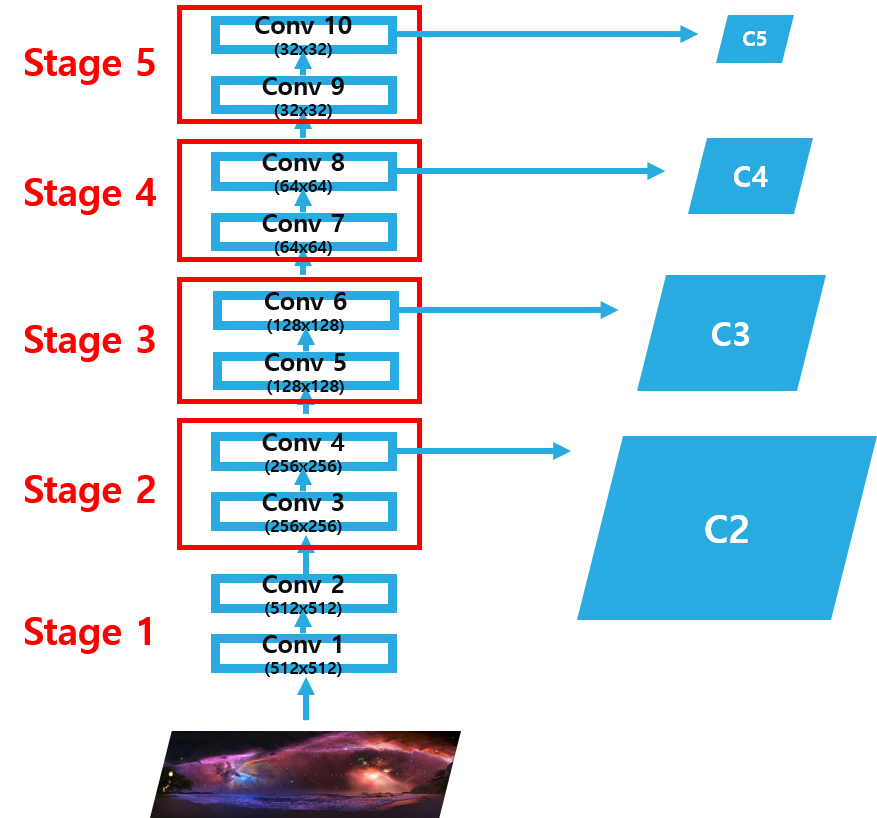

[참고 링크2](https://herbwood.tistory.com/18)

엄청 놀라운 이유는 아니었는데, stage1쪽의 output feature map은 많은 메모리를 차지하기 때문에 피라미드에서 제외되었다고 합니다..  
아마 이번 예제에서 stage2의 output을 사용하지 않은 이유도 이 때문이 아닐까 싶습니다.

그래서 이 뽑아낸 feature map들을 upsampling하는 것까진 이해했습니다. level간 output들을 더하기 위해서니까요.  

..그런데 왜 더하는 걸까요?

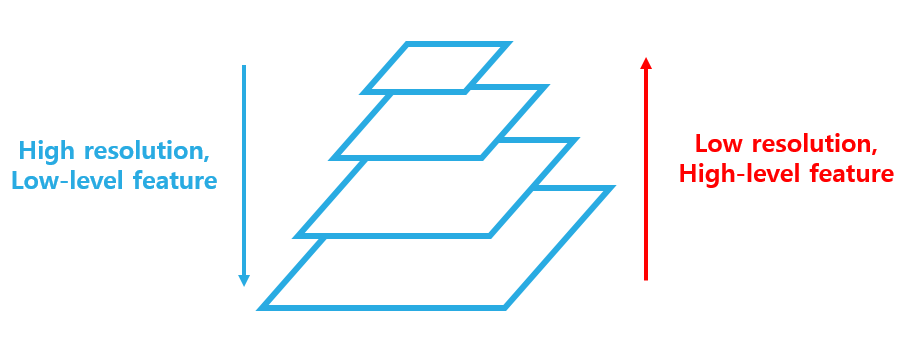

고해상도 feature map은 low-level feature를 가지지만 객체의 위치에 대한 정보를 상대적으로 정확하게 보존한다고 합니다. 당연히 원본 이미지에 더 가깝기 때문입니다.  
반면 저해상도 high-level feature는 해상도는 낮은 대신 class를 추론하는데 사용할 수 있는 질감, 물체의 일부분 등과 같은 high-level feature를 가집니다.

저해상도 이미지가 가진 고수준 특징을 고해상도 이미지가 가진 객체의 위치 정보와 더한다면 이 연산을 수행하지 않은 feature map보다 당연히 object detection에 더 유리한 많은 정보를 담을 수 있습니다.

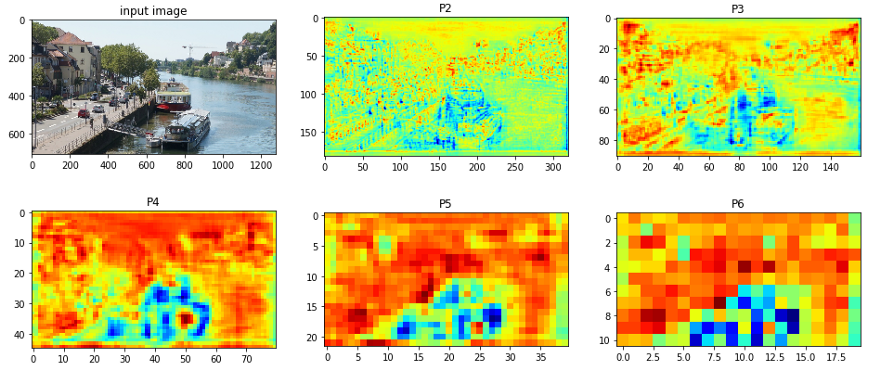

결과적으로 위와 같이 된다고 합니다.

In [88]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [89]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [90]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

In [91]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

### 모델 학습

In [21]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

In [22]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [23]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [24]:
import pickle

model_dir = os.getenv('HOME') + '/aiffel/Going_Deeper/object_detection/checkpoints/'
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 20

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

file_dir = os.getenv('HOME') + '/aiffel/Going_Deeper/object_detection/history.pkl'
with open(file_dir, 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/20
3173/3173 [==============================] - 1603s 501ms/step - loss: 2.3310 - val_loss: 1.5577

Epoch 00001: saving model to /aiffel/aiffel/Going_Deeper/object_detection/checkpoints/weights_epoch_1
Epoch 2/20
3173/3173 [==============================] - 1586s 499ms/step - loss: 1.0238 - val_loss: 1.2636

Epoch 00002: saving model to /aiffel/aiffel/Going_Deeper/object_detection/checkpoints/weights_epoch_2
Epoch 3/20
3173/3173 [==============================] - 1585s 499ms/step - loss: 0.7335 - val_loss: 1.1829

Epoch 00003: saving model to /aiffel/aiffel/Going_Deeper/object_detection/checkpoints/weights_epoch_3
Epoch 4/20
3173/3173 [==============================] - 1585s 499ms/step - loss: 0.5879 - val_loss: 1.0655

Epoch 00004: saving model to /aiffel/aiffel/Going_Deeper/object_detection/checkpoints/weights_epoch_4
Epoch 5/20
3173/3173 [==============================] - 1585s 499ms/step - loss: 0.4951 - val_loss: 0.9697

Epoch 00005: saving model to /aiffel/aiffel/Going_De

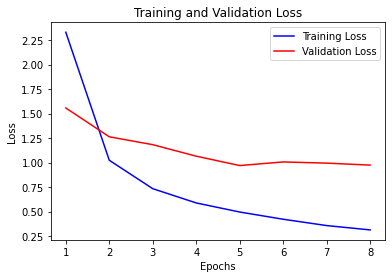

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 결과 확인하기

In [92]:
model_dir = os.getenv('HOME') + '/aiffel/Going_Deeper/object_detection/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

In [93]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [94]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)# confidence_threshold가 디텍션 결과와 관련이 있습니다.
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [95]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[1, 0, 0]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [96]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

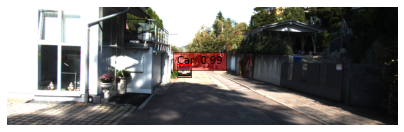

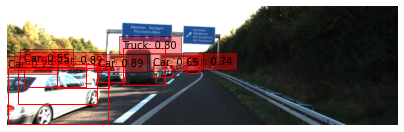

In [97]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

## 1. 자율주행 시스템 만들기

In [98]:
txt_path = os.getenv('HOME')+'/aiffel/object_detection/data/kitti/3.2.0/objects-type.labels.txt'

with open(txt_path, 'r') as f:
    contents = f.read()
    print(contents)

Car
Van
Truck
Pedestrian
Person_sitting
Cyclist
Tram
Misc



KITTI 데이터셋의 클래스는 위와 같이 총 8개로 구성됩니다.  

여기서 Car, Van, Truck은 차량으로, Pedestrian, Person_sitting, Cyclist는 사람으로 분류하겠습니다. (Tram과 Misc는 일단 제외했습니다.)

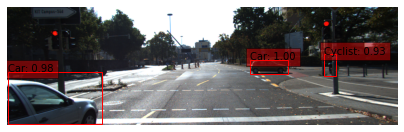

Stop!


'Stop'

In [107]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/data/stop_3.png'

def self_drive_assist(img_path, size_limit=300):
    image = Image.open(img_path)
    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    
    person = ['Pedestrian', 'Person_sitting', 'Cyclist']
    vehicle = ['Car', 'Van', 'Truck']
    
    if any(p in person for p in class_names): # 검출된 물체에 사람이 포함된다면
        print("Stop!")
        return "Stop"
    
    elif any(v in vehicle for v in class_names): # 검출된 물체에 차량이 포함된다면
        print("Well...")
        for [x_min, y_min, x_max, y_max] in detections.nmsed_boxes[0]:
            if all(coord == 0.0 for coord in [x_min, y_min, x_max, y_max]): # [[검출된 박스 좌표], [0, 0, 0, 0]]순으로 데이터가 저장됨
                print("Go~")              # 따라서 [0, 0, 0, 0]차례가 오면 바로 for문을 종료시켜 쓸데없이 for문을 추가로 돌리지 않게 함
                return "Go" # 300픽셀 이상의 차량이 없다면
            
            h = y_max - y_min # 검출된 물체의 세로
            w = x_max - x_min # 검출된 물체의 가로
            if h >= 300 or w >= 300: # 가로 혹은 세로가 300픽셀 이상이라면
                print("Stop!")
                return "Stop"
            
    else: # 사람도 차량도 없다면    
        print("Go~")
        return "Go"

self_drive_assist(img_path)

## 2. 자율주행 시스템 평가하기

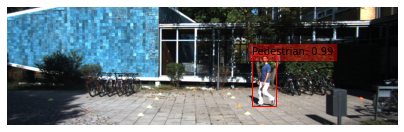

Stop!


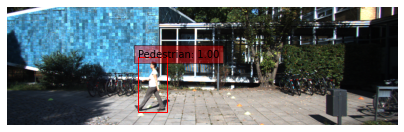

Stop!


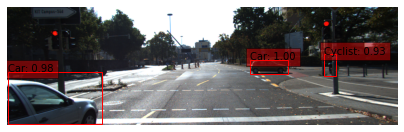

Stop!


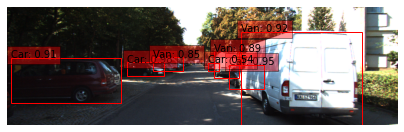

Well...
Stop!


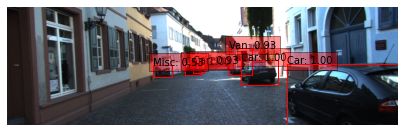

Well...
Stop!


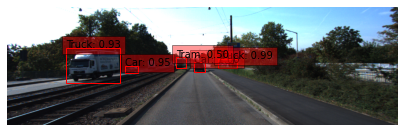

Well...
Go~


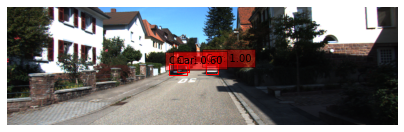

Well...
Go~


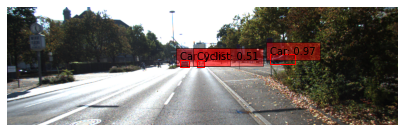

Stop!


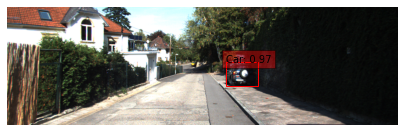

Well...
Go~


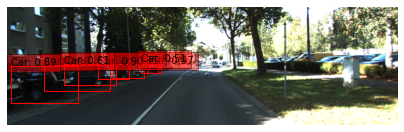

Well...
Go~
90점입니다.


In [108]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

90점이 나오는 것을 알 수 있습니다.  
Go3 이미지가 Cyclist때문에 사람이 있으니 바로 Stop하라고 판단한 것 같습니다.  
그런데 이미지가 너무 작아서 잘 안보이는데 제대로 판단하긴 한걸까요?

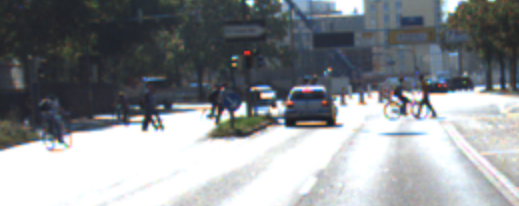

확대해서 보니 진짜로 자전거를 탄 사람이 있네요ㅋㅋ

그렇다면 100점이 나오려면 어떻게 해야할까요?  
방법이야 여러 가지가 있겠지만..  
지금 이 상황에서 당장 수행할 수 있는 방법은 다음과 같습니다.
- **자전거를 탄 사람을 차량 클래스로 분류**한다(법적으로도 자전거는 차량이니까 맞을지도..)
- **detections** = DecodePredictions(confidence_threshold=0.5)(image, predictions)에서 **임계값을 변경**한다(예를 들어 0.52로 변경하면 지금 당장 해당 이미지에선 Cyclist가 인식이 안되게 됨으로써 Go를 Stop으로 예측하는 문제를 해결할 수는 있습니다...만 이건 전반적인 인식률과 관련된 문제이기에 건드리지 않는 것이 좋을 것 같습니다. 물체가 있는데 없다고 판단해서 가는 것보단 없는데 있다고 판단해서 멈추는 것이 더 나으니까요..)

첫 번째 해결 방안이 더 현실적인 것 같으니 한번 적용해보겠습니다.

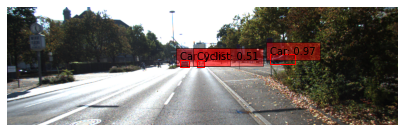

Well...
Go!


'Go'

In [109]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/data/go_3.png'

def self_drive_assist(img_path, size_limit=300):
    image = Image.open(img_path)
    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    
    person = ['Pedestrian', 'Person_sitting']
    vehicle = ['Car', 'Van', 'Truck', 'Cyclist']
    
    if any(p in person for p in class_names): # 검출된 물체에 사람이 포함된다면
        print("Stop!")
        return "Stop"
    
    elif any(v in vehicle for v in class_names): # 검출된 물체에 차량이 포함된다면
        print("Well...")
        for [x_min, y_min, x_max, y_max] in detections.nmsed_boxes[0]:
            if all(coord == 0.0 for coord in [x_min, y_min, x_max, y_max]): # [[검출된 박스 좌표], [0, 0, 0, 0]]순으로 데이터가 저장됨
                print("Go!")                     # 따라서 [0, 0, 0, 0]차례가 오면 바로 for문을 종료시켜 쓸데없이 for문을 추가로 돌리지 않게 함
                return "Go" # 300픽셀 이상 크기의 차량이 없다면
            
            h = y_max - y_min # 검출된 물체의 세로
            w = x_max - x_min # 검출된 물체의 가로
            if h >= 300 or w >= 300: # 가로 혹은 세로가 300픽셀 이상이라면
                print("Stop!")
                return "Stop"
            
    else: # 사람도 차량도 없다면    
        print("Go~")
        return "Go"

self_drive_assist(img_path)

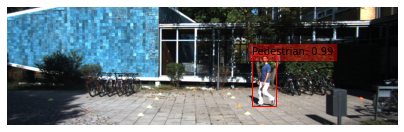

Stop!


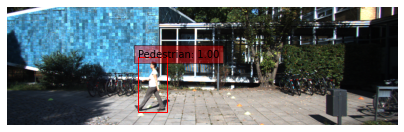

Stop!


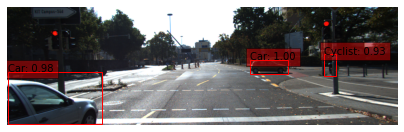

Well...
Stop!


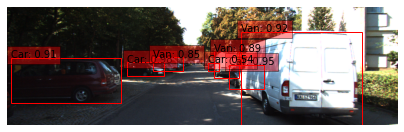

Well...
Stop!


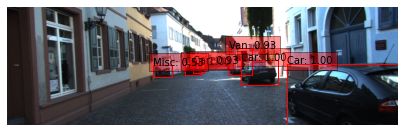

Well...
Stop!


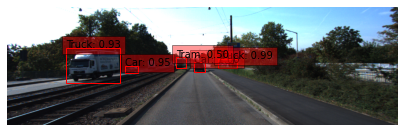

Well...
Go!


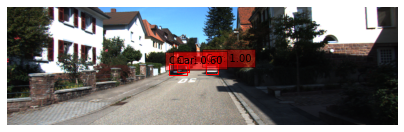

Well...
Go!


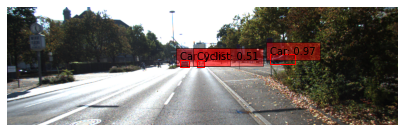

Well...
Go!


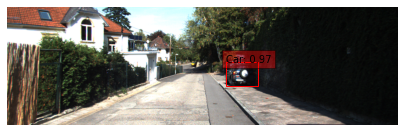

Well...
Go!


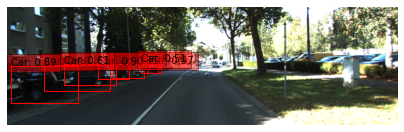

Well...
Go!
100점입니다.


In [110]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

예상한 대로 결과가 나오는 것을 확인할 수 있습니다.  


다만 앞서 설명한 대로 이 기준을 결정하는 것은 까다로운 문제입니다. 지금과 같이 자전거 탄 사람을 차량으로 분류할지의 여부는 비교적 간단하지만 더 복잡한 경우엔 함부로 기준을 정할 수 없기에..(극단적으론 운전자와 상대방의 생명이 걸린 돌발상황의 예시에서 자율주행 자동차가 어떤 선택을 해야할지 등..)

## 정리

- 앵커박스라는 개념을 사용하여 객체를 인식한다.
- 앵커박스는 여러가지 형태(가로로 긴, 세로로 긴, 정사각형 등)와 여러가지 크기(작음, 중간, 큼 등)로 생성한다.
- 앵커박스의 형태는 정답 바운딩 박스와 iou를 계산하여 바운딩 박스와 비슷하게 생긴 앵커박스를 선택한다.
- 비최대 억제 방식을 사용하여 같은 물체를 탐지한 앵커박스들 중 제일 정답과 비슷한 것만 남긴다.
- Feature Pyramid는 backbone 네트워크의 각 레벨의 출력 feature map들을 가져와 upsampling하고 더하여 여러 스케일에서 이미지의 객체를 검출할 수 있다.
- 자율주행 시스템을 설계하는데 있어서 자율주행 시스템이 내리는 판단의 기준은 사람이 임의로 정해줘야 한다.